In [2]:
model_name="avichr/Legal-heBERT"

In [3]:
from transformers import AutoTokenizer

In [4]:
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [5]:
import datasets
data = datasets.load_dataset('LevMuchnik/SupremeCourtOfIsrael')

Found cached dataset parquet (/home/user/.cache/huggingface/datasets/LevMuchnik___parquet/LevMuchnik--SupremeCourtOfIsrael-7f46ab7220db2581/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
import pandas as pd
import re
from tqdm.notebook import tqdm

# parsing

In [7]:
def get_paragraphs(text_list):
    ans = []
    # Regex to match paragraph separators
    paragraph_separator = re.compile(r'(\n\s*)+\n')
    bads = (
            re.compile(r'<!--\s*\n\s*/\*\s*Font Definitions\s*\*/'),
            re.compile(r'\uFFFD'),
            re.compile(r'endstream.*?(?=\n|$)'),
            re.compile(r'/Author \(user\)\n|/Creator'),
           )
            

    
    for doc_idx, text in enumerate(text_list):
        if not text:
            continue

        # Splitting text into paragraphs using the defined regex
        paragraphs = paragraph_separator.split(text)

        count = 0
        for paragraph in paragraphs:
            skip=False
            for b in bads:
                if b.search(paragraph):
                    skip=True
                    break

            if skip:
                continue

            paragraph = paragraph.strip()  # Stripping whitespace
            # Only add non-empty paragraphs
            if paragraph:
                ans.append({'doc': doc_idx, 'count': count, 'text': paragraph})
                count += 1

    return ans

In [8]:
pars=get_paragraphs(tqdm(data['train']['text']))

  0%|          | 0/751194 [00:00<?, ?it/s]

In [9]:
def length(s):
    if not s:
        return 0
    s=" ".join(s.split('\n'))
    return len(s.split(' '))

In [10]:
df=pd.DataFrame({'text':[p['text'] for p in pars]})#[0].hist(bins=100)
df['length']=df['text'].map(length)
df

,text,length
0,בבית המשפט העליון,3
1,"בג""ץ \n 5856/03 - י'",7
2,בפני:,1
3,כבוד השופטת ד' דורנר,4
4,כבוד השופטת מ' נאור,4
...,...,...
24978820,_________________________,1
24978821,22063560_O01.docx,1
24978822,שצ,1
24978823,"מרכז מידע, טל' 077-2703333, 3852* ;\nאתר אינטרנט,",8


0.14025819869429407


array([[<Axes: title={'center': 'length'}>]], dtype=object)

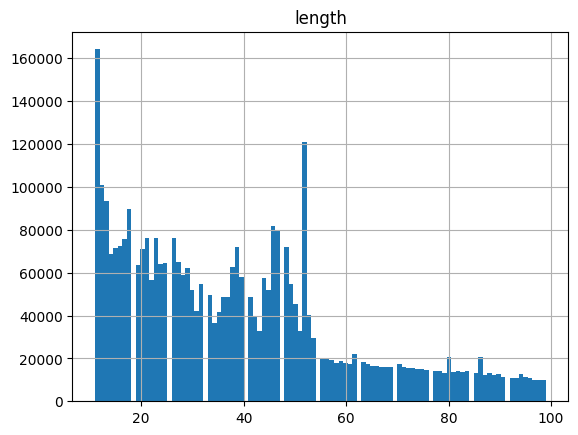

In [11]:
cut_df=df[df['length'].map(lambda x: 10<x<100)]
print(len(cut_df)/len(df))
cut_df.hist(bins=100)

In [12]:
cut_df

,text,length
14,בשם העותר: בעצמו,28
15,"בשם המשיבים: עו""ד שי\nניצן",26
18,1. העתירה שבפנינו עניינה בבקשת העותר כי...,47
20,3. על שני עניינים אלה יצא קצפו של העותר...,73
21,"4. דין העתירה להידחות על הסף, שכן העותר...",86
...,...,...
24978752,"לבקשת\nהמדינה, ובהסכמת ב""כ המשיבים 2-1, מוארך ...",32
24978773,"בקשה להארכת מעצר\n שלישית, בהסכמה, לפי סעיף 6...",21
24978779,"לבקשת המדינה,\nובהסכמת ב""כ המשיב, מוארך בזאת מ...",29
24978804,"בקשה להארכת מעצר,\n בהסכמה, לפי סעיף 62 לחוק ...",20


In [13]:
cut_df['text'].iloc[100]

'נוסח \nזה  כפוף  לשינויי עריכה טרם  פרסומו'

# new filter

In [14]:
# def is_valid_utf8(text):
#     try:
#         text.encode('utf-8').decode('utf-8')
#         return True
#     except UnicodeDecodeError:
#         return False

In [15]:
def filter_bads(text_list):
    ans = []

    bads = (
            re.compile(r'<!--\s*\n\s*/\*\s*Font Definitions\s*\*/'),
            re.compile(r'\uFFFD'),
            re.compile(r'endstream.*?(?=\n|$)'),
            re.compile(r'/Author \(user\)\n|/Creator'),
            re.compile(r'\ue51d'),
            re.compile(r'[\u0080-\u00FF\u0100-\u017F]'), #weird latin dialects like ã
           )
            

    
    for doc_idx, text in enumerate(text_list):
        if not text:
            continue
        text=text.strip()
        
        if text in ("File not found",""):
            continue
            
        skip=False
        for b in bads:
            if b.search(text):
                skip=True
                break
        if skip:
            continue

        # if not is_valid_utf8(text):
        #     continue
        
        text=re.sub(r'\n\s*\n\s*\n+', '\n\n', text)
        ans.append({'doc': doc_idx,  'text': text})

    return ans

In [16]:
filtered=filter_bads(tqdm(data['train']['text']))

  0%|          | 0/751194 [00:00<?, ?it/s]

In [17]:
df=pd.DataFrame({'text':[p['text'] for p in filtered] ,'doc':[p['doc'] for p in filtered]})#[0].hist(bins=100)
df['length']=df['text'].map(length)
df

,text,doc,length
0,"בבית המשפט העליון\n\nבג""ץ \n 5856/03 - י'\n\n...",0,698
1,"בבית המשפט\n העליון\n\nבג""ץ \n 5856/03 \n\nב...",1,273
2,"בבית המשפט העליון\n\nבג""ץ \n 5856/03 - י'\n\n...",2,267
3,"בבית המשפט\n העליון\n\nבג""ץ \n 5856/03 - א'\...",3,248
4,"בבית המשפט העליון\n\nבג""ץ \n 5856/03 - ד'\n\n...",4,243
...,...,...,...
691507,"בבית המשפט העליון\n\nבש""פ\n \n6336/22\n\nלפני...",751189,137
691508,"בבית המשפט העליון\n\nבש""פ\n \n6338/22\n\nלפני...",751190,142
691509,"בבית המשפט העליון\n\nבש""פ\n \n6352/22\n\nלפני...",751191,185
691510,"בבית המשפט העליון\n\nבש""פ\n \n6355/22\n\nלפני...",751192,139


In [18]:
len(df)/len(data['train'])

0.920550483630061

In [19]:
df['length'].sum()#/sum(length(t) for t in data['train']['text'])

333431965

<Axes: >

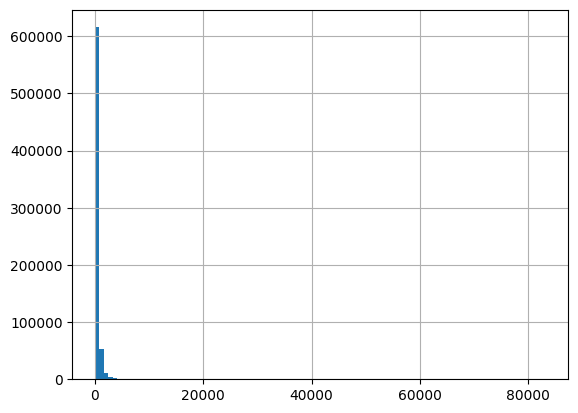

In [20]:
df['length'].hist(bins=100)

In [21]:
s=df.sort_values(by='length')
s

,text,doc,length
33020,COURT,33771,1
798,97018640.\nI11,824,2
10156,הטיוטה נמחקה -,10388,3
29128,שמריהו כהן - מזכיר ראשי,29827,5
58739,2\n\n3\n\n2,59827,5
...,...,...,...
459651,בבית המשפט העליון בשבתו כבית משפט\n לערעורים ...,507855,83252
487518,בבית המשפט העליון בשבתו כבית משפט\n לערעורים ...,538891,83252
464582,בבית המשפט העליון בשבתו כבית משפט\n לערעורים ...,513593,83252
461696,בבית המשפט העליון בשבתו כבית משפט\n לערעורים ...,510285,83252


In [22]:
print(s['text'].iloc[5])

החלטה שונתה לפסק דין נמצא בהרכב


In [23]:
filtered[s.index[5]]

{'doc': 36578, 'text': 'החלטה שונתה לפסק דין נמצא בהרכב'}

In [24]:
data['train']['text'][36578]

'\n\n\n\n\n\nהחלטה שונתה לפסק דין נמצא בהרכב\n\n\n\n\n\n\n\n\n'

In [25]:
(df['text']=='COURT').sum()

1

In [26]:
cut=s[df['length'].map(lambda x: 30<x<500)]
print(len(cut)/len(df))
cut

0.7443587385323754


/tmp/ipykernel_69583/237526988.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cut=s[df['length'].map(lambda x: 30<x<500)]


,text,doc,length
10155,ב\nבית המשפט העליון\n בשבתו כבית-משפט גבוה לצד...,10387,35
214136,בפני: \n\nנ\n \nג\n \nד\n\nתאריך הישיבה:\n...,217125,36
119621,העתק מתאים למקור\n \nCOURT.DOT\n\nנוסח \nזה ...,121254,43
90509,"בבית המשפט העליון\n\nבג""ץ \n 3700/00\n\nבפני:...",91896,62
617079,"בבית המשפט העליון\n\nמ""ח\n \n6881/19\n\nלפני:...",676232,63
...,...,...,...
83566,"ב\nבית המשפט העליון\n\nבה""נ \n4818/00\n\nבפני ...",84869,499
93940,"ב\nבית המשפט העליון\n\nרע""פ \n2259/00 - א'\n\n...",95346,499
51392,"ב\nבית המשפט העליון\n\nבה""נ \n1708/98\n\nבפני\...",52391,499
107776,"ב\nבית המשפט העליון\n\nבה""נ \n6410/00\n\nבפני ...",109325,499


In [27]:
print(cut['text'].iloc[5])

בבית המשפט העליון
 בירושלים

בש"פ 
  7564/03

בפני:   

כבוד השופטת ד' ביניש

העורר:

חנניה אלמקייס

נ
  
ג
  
ד

המשיבה:

מדינת ישראל

בקשה לשמיעת הערר יחד עם ערר אחר

החלטה

_________________________

העותק כפוף לשינויי עריכה וניסוח.

03075640_N01.doc
/צש

מרכז מידע, טל' 02-6750444 ; אתר אינטרנט,  
www.court.gov.il


In [28]:
data['train']['text'][cut['doc'].iloc[1]]

"\n\n\n\n\n\n\n\n\n\n \n\n  \n\n  \n \n\n  \n \n\n  \n\n \n\n \n\n  \n\n  \n \n\n  \n\n \n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n \n\n  \n\n  \n \n\n  \n\n \n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n \n\n  \n\n  \n     \n\n  \n\n \n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n \n\n  \n\n  \n \n\n  \n\n \n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n \n\n  \n\n  \nבפני:   \n\n  \n\n  \n\n  \n \n\n  \n\n \n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n \n\n  \n\n  \n \n\n  \n\n  \n\n  \n \n\n  \n\n \n\n\n\n\n\n\n\n\n                                           \n\n\n\n\n\n\n\n \n\n  \n\n  \n \n\n  \n\n  \n\n  \nנ\n  \nג\n  \nד\n\n  \n\n \n\n\n\n\n\n\n\n\n                                                                                                    \n\n\n\n\n\n\n\n\n \n\n  \n\n  \n \n\n  \n\n  \n\n  \n \n\n  \n\n \n\n\n\n\n\n\n\n\n                                           \n\n\n\n\n\n\n\n \n\n  \n\n  \n \n\n  \n\n \n\n\n\n\n\n\n\n\n                                           \n\n\n\n\n\n\n\n \n\n  \n\n  \nתאריך הישיבה:\n\n  \n\n  \n\n 

In [29]:
print(s['text'].iloc[-1].split('\n\n')[-9])

בהמשך
לחוות דעת הממונה על עבודות שירות בעניין בן חיים, ולנוכח חלוף הזמן, הממונה יגיש
עד לתאריך 30.3.2017 חוות דעת בדבר המקום בו יתייצב הנ"ל לריצוי עבודות
השירות לתקופה של שישה חודשים. ריצוי העונש האמור יחל בתאריך 20.4.17 בשעה 9:00. 


In [30]:
len(tokenizer.encode(s['text'].iloc[-1]))

114232

In [31]:
len(tokenizer.encode(cut['text'].iloc[-1]))

590

In [35]:
df[df['text'].map(lambda t:bool([x for x in t.split('\n\n') if length(x)>30]))]['length'].sum()

300020114

In [171]:
print(s['text'].iloc[-1])

בבית המשפט העליון בשבתו כבית משפט
  לערעורים פליליים

ע"פ
  
7621/14

ע"פ
  
7647/14

ע"פ
  
7680/14

ע"פ
  
7777/14

ע"פ
  
8495/14

ע"פ
  
80/15

ע"פ
  
572/15

ע"פ
  
590/15

לפני:

כבוד השופט נ' הנדל

כבוד השופט י' עמית

כבוד השופטת ד' ברק-ארז

המערער בע"פ 7621/14 (המשיב
  בע"פ 7647/14):

אהרן גוטסדינר

המערער בע"פ 7680/14 (המשיב
  בע"פ 7647/14):

מאיר רואימי

המערער בע"פ 7777/14 (המשיב
  בע"פ 7647/14):

יצחק אוחנה

המערער בע"פ 8495/14 (המשיב
  בע"פ 7647/14):

מאיר רוזנטל

המערער בע"פ 80/15 (המשיב
  בע"פ 572/15):

חיים בן חיים

המערער בע"פ 590/15:

שרון אפריאט

נ
  
ג
  
ד

המשיבה
 
(המערערת
  בע"פ 7647/14 וע"פ 572/15):

מדינת ישראל

ערעורים על פסק
  דינו של בית המשפט המחוזי בירושלים מיום 29.09.2014 בת"פ 260/08 שניתן על
  ידי כבוד השופט א' כהן

בשם המערער בע"פ 7621 והמשיב
  בע"פ 7647/14:

עו"ד ליזי שובל-בר 

בשם המערער בע"פ 7680/14 והמשיב
  בע"פ 7647/14:

עו"ד מיכאל עירוני

בשם המערער בע"פ 7777/14 והמשיב
  בע"פ 7647/14:

עו"ד דבורה אטיה

בשם המערער בע"פ 8495/14 והמשיב
  בע"פ 7647/1

In [180]:
df['length']==df['text'].map(lambda t: len(t.replace('\n\n','\n').split('\n')))

0         False
1         False
2         False
3         False
4         False
          ...  
691507    False
691508    False
691509    False
691510    False
691511    False
Length: 691512, dtype: bool